<a href="https://colab.research.google.com/github/Jevaan21/intrusion-detection-dl/blob/main/intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Android Malware Detection using Deep Learning (Drebin dataset)
# Developed as a group project for Deep Learning Implementation (DLI)


/tmp/ipython-input-3309192873.py:24: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("drebin.csv")


Missing values before clean: 0
Missing before drop: 5
Missing after  drop: 0

📊 Logistic Regression Baseline
              precision    recall  f1-score   support

         0.0     0.9794    0.9809    0.9801      1886
         1.0     0.9678    0.9652    0.9665      1121

    accuracy                         0.9751      3007
   macro avg     0.9736    0.9731    0.9733      3007
weighted avg     0.9750    0.9751    0.9751      3007


⏳ Enhanced model training started at: 2025-08-08 10:10:24
Epoch 1/10
94/94 - 3s - 34ms/step - accuracy: 0.9355 - loss: 0.1623 - val_accuracy: 0.9721 - val_loss: 0.2105
Epoch 2/10
94/94 - 1s - 8ms/step - accuracy: 0.9803 - loss: 0.0638 - val_accuracy: 0.9814 - val_loss: 0.1112
Epoch 3/10
94/94 - 1s - 9ms/step - accuracy: 0.9852 - loss: 0.0450 - val_accuracy: 0.9824 - val_loss: 0.0674
Epoch 4/10
94/94 - 1s - 13ms/step - accuracy: 0.9900 - loss: 0.0335 - val_accuracy: 0.9847 - val_loss: 0.0497
Epoch 5/10
94/94 - 1s - 15ms/step - accuracy: 0.9914 - loss: 0.0264

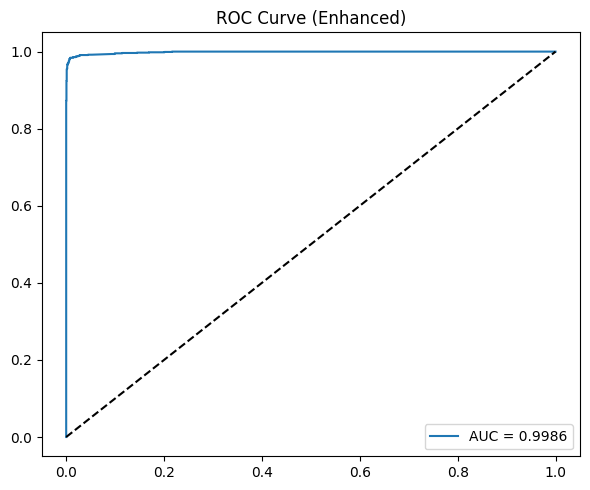

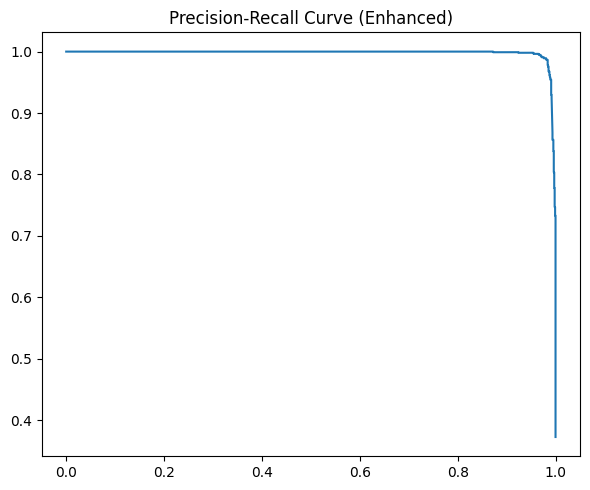

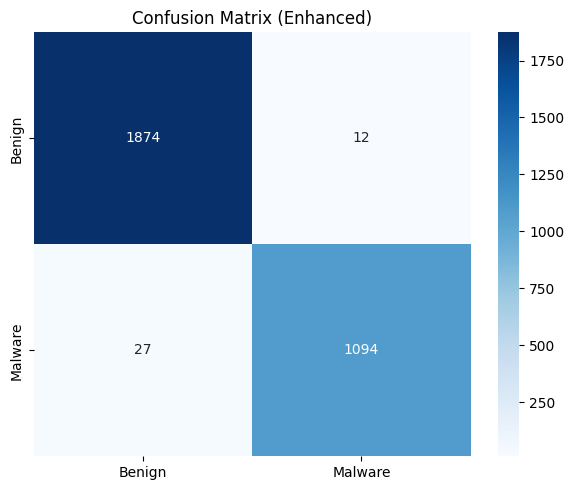

(None, None)

In [ ]:
import random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, f1_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ─── 1) Reproducibility & Data Loading ────────────────────────────────────────
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

!wget -q https://raw.githubusercontent.com/Jevaan21/intrusion-detection-dl/main/drebin-215-dataset-5560malware-9476-benign.csv -O drebin.csv
data = pd.read_csv("drebin.csv")
print("Missing values before clean:", data.isna().sum().sum())

# ─── 2) Clean & Encode ─────────────────────────────────────────────────────────
# 🎯 Step: Encode class labels ('B'/'S') → (0/1)
le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])

# 🧹 Step: Clean stray '?' in feature columns only
feat_cols = data.columns.difference(['class'])
data[feat_cols] = data[feat_cols].replace('[?]', np.nan, regex=True)

# 🧹 Drop any rows with missing feature values
print("Missing before drop:", data.isna().sum().sum())
data.dropna(inplace=True)
print("Missing after  drop:", data.isna().sum().sum())


# ─── 3) Split & Reshape ────────────────────────────────────────────────────────
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:,  -1].to_numpy().reshape(-1,1)

train_x, test_x, train_y, test_y = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# 🔧 Ensure all arrays are numeric float32 for both sklearn & Keras
train_x = train_x.astype('float32')
test_x  = test_x.astype('float32')
train_y = train_y.astype('float32')
test_y  = test_y.astype('float32')

# ─── 4) Baseline: Logistic Regression ─────────────────────────────────────────
lr = LogisticRegression(max_iter=1000)
lr.fit(train_x, train_y.ravel())
y_pred_lr = lr.predict(test_x)
print("\n📊 Logistic Regression Baseline")
print(classification_report(test_y, y_pred_lr, digits=4))
# ─── 5) Enhanced Deep Learning Model ──────────────────────────────────────────
enh_model = Sequential([
    Input(shape=(train_x.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

enh_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print("\n⏳ Enhanced model training started at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_enh = enh_model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=10, batch_size=128,
    callbacks=[es], verbose=2
)

# ─── 6) Compare Metrics Side-by-Side ──────────────────────────────────────────
f1_lr  = f1_score(test_y, y_pred_lr)
y_prob_enh = enh_model.predict(test_x).ravel()
y_pred_enh = (y_prob_enh > 0.5).astype(int)
f1_enh = f1_score(test_y, y_pred_enh)

print("\n✅ Side-by-Side F1 Comparison")
print(f" • Logistic Regression : {f1_lr:.4f}")
print(f" • Enhanced DL Model   : {f1_enh:.4f}")

# ─── 7) Plots for Enhanced Model ───────────────────────────────────────────────
# ROC
fpr, tpr, _ = roc_curve(test_y, y_prob_enh)
auc_enh = roc_auc_score(test_y, y_prob_enh)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_enh:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve (Enhanced)")
plt.legend(), plt.tight_layout(), plt.show()

# PR
prec, rec, _ = precision_recall_curve(test_y, y_prob_enh)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.title("Precision-Recall Curve (Enhanced)")
plt.tight_layout(), plt.show()

# Confusion Matrix
cm = confusion_matrix(test_y, y_pred_enh)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Benign","Malware"], yticklabels=["Benign","Malware"])
plt.title("Confusion Matrix (Enhanced)")
plt.tight_layout(), plt.show()

In [ ]:
# ─── 8) One-line verdict ───────────────────────────────────────────────────────
TARGET_F1 = 0.90  # ← set your target here
verdict = "target met" if f1_enh >= TARGET_F1 else "target not met"
print(f"Achieved F1 = {f1_enh:.2f}, {verdict}")

Achieved F1 = 0.98, target met
